# 3. Applying HMP to real data

For this tutorial we will use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. For the purpose of this tutorial we will only use the first 5 participants of the data (see the [HMP]((https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469)) paper for the method and [https://osf.io/29tgr/](https://osf.io/29tgr/) for the whole (preprocessed) data).

In this experiment, participants performed a random-dot motion task. They were asked to indicate the direction of motion of a cloud of moving dots. While a proportion of the dots moved in a target direction, the remainder moved randomly and makes the direction discrimination more difficult. Difficulty of the task was calibrated per subject. Prior to each trial, participants received a cue that indicated whether they should respond as quickly as possible or whether they should focus on giving an accurate response: the 'speed' and 'accuracy' conditions. In this tutorial we will ignore the difference between these conditions, but in the next tutorial we will look at how we can take conditions into account in the HMP analysis.

## Data preparation

First, we load the required packages and download the data. Depending on your internet connection this can take some time

In [1]:
import os
import requests
import numpy as np
import xarray as xr
import hmp
from mne.io import read_info
import matplotlib.pyplot as plt

# Declaring path where the EEG data will be stored
epoch_data_path = os.path.join('sample_data', 'eeg')
os.makedirs(epoch_data_path, exist_ok=True)

# URLs of the first 5 participants in the SAT experiment, navigate the osf folder and adapt those if you want to do this tutorial on other data (e.g. P3, N2pc)
file_urls = [
    "https://osf.io/download/67cffa85f67af67e7a92f0a6/",
    "https://osf.io/download/67cffa85f67af67e7a92f0a8/",
    "https://osf.io/download/67cffa85f67af67e7a92f0aa/",
    "https://osf.io/download/67cffa85f67af67e7a92f0ac/",
    "https://osf.io/download/67cffa85f67af67e7a92f0ae/",
]

# Download and save each file if not already in folder
for i, url in enumerate(file_urls, start=1):
    file_path = os.path.join(epoch_data_path, f'participant{i}_epo.fif')
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)

# Recovering individual files and participant names
subj_files = [os.path.join(epoch_data_path, f) for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Create a list of files with full paths
subj_names = [os.path.splitext(f)[0] for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Extract subject names based on file names

# Recovering channel information (assuming the same for all participant)
info = read_info(subj_files[0], verbose=False)

In [2]:
# At what frequency we want the data, upsample only if you have a large amount of RAM (and time)
# Note that upsampling usually doesn't improve the results, it is however useful if you want to use patterns that are shorter than the standard 50ms Halfsines
sfreq = 100

# Then we read the data as shown in Tutorial 1
epoch_data = hmp.io.read_mne_data(subj_files, data_format='epochs', sfreq=sfreq,
                            lower_limit_rt=0.2, upper_limit_rt=2, 
                            rt_col = 'RT', scale = 1000, #In this case the rts are contained in the dataframe column "RT" and is in milliseconds, thus we adapt 
                            verbose=False, subj_name=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

print(epoch_data)

Processing participant sample_data/eeg/participant3_epo.fif's epochs eeg
177 trials were retained for participant sample_data/eeg/participant3_epo.fif
Processing participant sample_data/eeg/participant4_epo.fif's epochs eeg
159 trials were retained for participant sample_data/eeg/participant4_epo.fif
Processing participant sample_data/eeg/participant5_epo.fif's epochs eeg
183 trials were retained for participant sample_data/eeg/participant5_epo.fif
Processing participant sample_data/eeg/participant1_epo.fif's epochs eeg
187 trials were retained for participant sample_data/eeg/participant1_epo.fif
Processing participant sample_data/eeg/participant2_epo.fif's epochs eeg
193 trials were retained for participant sample_data/eeg/participant2_epo.fif
<xarray.Dataset> Size: 47MB
Dimensions:      (participant: 5, epoch: 200, channel: 30, sample: 194)
Coordinates:
  * epoch        (epoch) int64 2kB 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * channel      (channel) <U3 360B 'Fp1' 'Fp2' 'AF

As you can see the HMP formatted EEG dataset contains some info on the experiment such as the sampling frequency, the number of trials, the number of participants, and the number of channels. The data is epoched between stimulus and response onset (RT) and it also contains metadata such as the RTs and other information on the experiment.

At this point we have the epoched EEG data with 30 channels, which we need to transform to PC space. When transforming the data, a prompt requests how many PCs we want to keep. The best is to maximise the number of components kept so that we don't lose information. However, the more PCs we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PCs that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method).

The HMP `preprocessing` module will show you the two graphs below, and asks you how many PCs you would like to retain:

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:196: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(


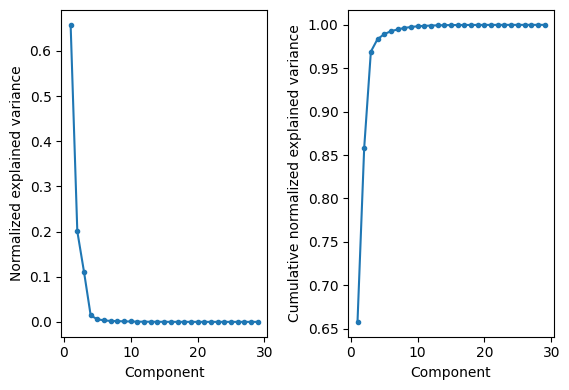

How many PCs (95 and 99% explained variance at component n3 and n6; components till n4 explain at least 1%)? 6


In [3]:
preprocessed = hmp.preprocessing.Standard(epoch_data)

In this case we see that 99% explained variance is achieved with 6 PCs, and that this is coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with more PCs).

In [4]:
print(preprocessed.data)

<xarray.DataArray (component: 6, all_samples: 64690)> Size: 3MB
array([[-0.37843614,  0.54970101,  1.18656407, ...,  1.6378993 ,
         1.18647756,  1.27125379],
       [-0.90974883, -1.34064728, -0.98165245, ..., -2.01661048,
        -2.62934806, -2.4849967 ],
       [-0.24744799, -0.26765736,  0.06243987, ...,  0.6490494 ,
        -0.11392254,  0.26422928],
       [ 0.53060647,  0.80575069,  0.2425211 , ..., -1.22800291,
        -1.32209665, -1.22543997],
       [-0.26560867, -0.54000581, -1.85716144, ..., -0.69323033,
        -0.20642558,  0.48890299],
       [ 1.80807049,  1.16127648, -0.45168922, ..., -0.75253032,
        -0.79259553, -1.67712504]], shape=(6, 64690))
Coordinates:
    stim         (all_samples) float64 518kB 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    resp         (all_samples) object 518kB 'resp_left' ... 'resp_right'
    RT           (all_samples) float64 518kB 907.0 907.0 907.0 ... 350.0 350.0
    cue          (all_samples) object 518kB 'AC' 'AC' 'AC' ... 'AC' 'AC

The data is now arranged as 6 PCs x 64690 samples: all trials of all participants were concatenated for the remainder of the analysis.

Finally, we need to initialize the model.

In [5]:
# Defining the expected HMP pattern
event_properties = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
# Performing the crosscorrelation between the preprocessed data and the expected pattern
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed, pattern=event_properties.template)

## Fitting

As introduced in Tutorial 2, the ```CumulativeEstimation``` method starts by sliding a candidate event from 0 to mean RT. When an event is found – the Expectation Maximization estimation converges – one event is added to the model and the slide continues. This way we can detect new events while accounting for the previous ones. 

In [6]:
model = hmp.models.CumulativeMethod(event_properties)
_, estimates_cumulative = model.fit_transform(trial_data)

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 1 found around time 90.0
Transition event 2 found around time 280.0
Transition event 3 found around time 500.0
Transition event 4 found around time 690.0

All events found, refitting final combination.
Estimating 4 events model


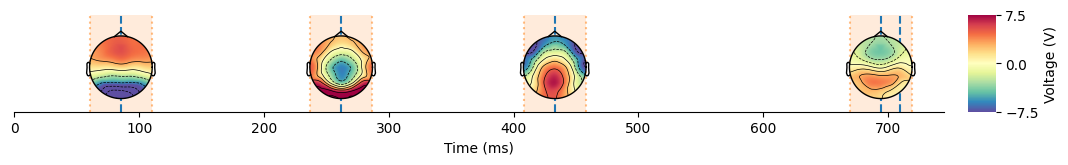

In [7]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_cumulative, info, as_time=True,  vmin=-7.5,  vmax=7.5,)

## Example application 1: looking at individual topographies

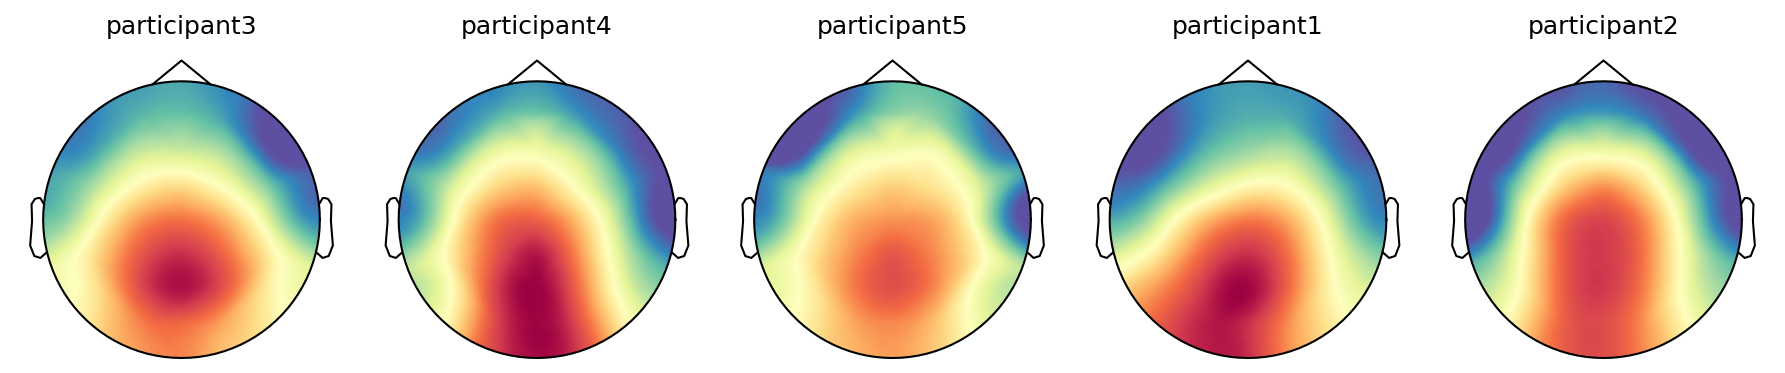

In [8]:
# Plotting individual topographies for a specific event across participants
from mne.viz import plot_topomap

# Get event-channel weights for each trial
by_trial_weights = hmp.utils.event_channels(epoch_data, estimates_cumulative, mean=False)

# Plot topographies for each participant for a selected event
fig, axes = plt.subplots(1, 5, dpi=150, figsize=(12, 2.5))
axes = axes.flatten()
event = 3  # Event index to plot (1-based for display, 0-based for indexing)

for i, participant in enumerate(epoch_data.participant):
    ax = axes[i]
    # Average across epochs for the selected event and participant
    topo = by_trial_weights.sel(event=event-1, participant=participant).mean('epoch')
    plot_topomap(
        topo,
        info,
        sensors=False,
        cmap='Spectral_r',
        res=100,
        show=False,
        axes=ax,
        contours=False
    )
    ax.set_title(f'{str(participant.values)[:-4]}')

plt.tight_layout()

## Example application 2: analyzing condition effect on interval between events

In [9]:
# Compute max likely time for each trial and each event
times =  hmp.utils.event_times(estimates_cumulative, duration=True, add_rt=True, as_time=True)
times

<xarray.DataArray (trial: 899, event: 5)> Size: 36kB
array([[ 70., 160., 220., 420.,  30.],
       [130., 220., 270., 460.,  10.],
       [120., 220., 480., 530.,  10.],
       ...,
       [170., 170.,  70.,  90.,  20.],
       [140., 100., 150.,  60.,  10.],
       [ 60., 180.,  60.,  30.,  10.]], shape=(899, 5))
Coordinates:
  * trial        (trial) object 7kB MultiIndex
  * participant  (trial) object 7kB 'participant3_epo' ... 'participant2_epo'
  * epoch        (trial) int64 7kB 0 2 3 5 7 8 9 ... 192 193 194 195 197 198 199
  * event        (event) int64 40B 0 1 2 3 4
    group        (trial) int8 899B 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [10]:
# Turn into dataframe and recover metadata
times = times.unstack().to_dataframe(name='duration')
times = times[~times.duration.isna()]  #Remove rejected trials
times = times.reset_index().set_index(['participant','epoch'])

# Recover metadata and merge with times
times_metadata = epoch_data.sel(sample=0, channel='Cz').to_dataframe().iloc[:,3:]
times_metadata = times_metadata.reset_index().set_index(['participant','epoch'])
times = times.merge(times_metadata, on=['participant','epoch'])

times

event  group  duration  stim        resp      RT cue  \
participant      epoch                                                         
participant1_epo 1          0    0.0     160.0   1.0   resp_left   683.0  SP   
                 2          0    0.0      40.0   1.0  resp_right  1068.0  AC   
                 3          0    0.0      20.0   1.0  resp_right   994.0  SP   
                 4          0    0.0     190.0   1.0   resp_left  1352.0  AC   
                 5          0    0.0      40.0   2.0   resp_left   722.0  SP   
...                       ...    ...       ...   ...         ...     ...  ..   
participant5_epo 193        4    0.0      10.0   1.0  resp_right   555.0  AC   
                 194        4    0.0      10.0   1.0   resp_left   418.0  AC   
                 195        4    0.0      10.0   1.0  resp_right   377.0  SP   
                 197        4    0.0      20.0   1.0  resp_right   649.0  AC   
                 199        4    0.0      10.0   1.0  resp_right   301.0  AC   

                          movement                  trigger  
participant      epoch                                       
participant1_epo 1       stim_left   SP/stim_left/resp_left  
                 2       stim_left  AC/stim_left/resp_right  
                 3       stim_left  SP/stim_left/resp_right  
                 4       stim_left   AC/stim_left/resp_left  
                 5      stim_right  SP/stim_right/resp_left  
...                            ...                      ...  
participant5_epo 193     stim_left  AC/stim_left/resp_right  
                 194     stim_left   AC/stim_left/resp_left  
                 195     stim_left  SP/stim_left/resp_right  
                 197     stim_left  AC/stim_left/resp_right  
                 199     stim_left  AC/stim_left/resp_right  

[4495 rows x 9 columns]

Text(0.5, 1.0, 'Event durations by condition')

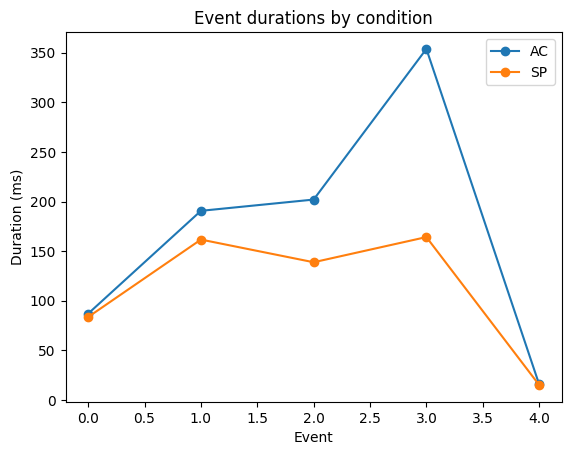

In [11]:
mean_ac = times[times.cue == 'AC'].groupby(['event']).duration.mean()
mean_sp = times[times.cue == 'SP'].groupby(['event']).duration.mean()

plt.plot(mean_ac.index, mean_ac.values, 'o-', label='AC')
plt.plot(mean_sp.index, mean_sp.values, 'o-', label='SP')
plt.legend()
plt.xlabel('Event')
plt.ylabel('Duration (ms)')
plt.title('Event durations by condition')

## Example application 3: Comparing conditions on centered ERPs:

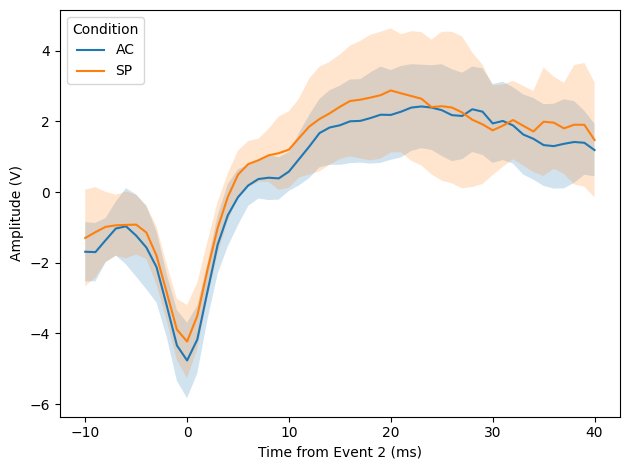

In [12]:
# Plotting centered ERPs for each condition (AC and SP) with confidence intervals (±1 std)
fig, ax = plt.subplots(1,1)

# Get event times (positions not durations) for all events/trials, including stimulus onset
times_position = hmp.utils.event_times(estimates_cumulative, duration=False, mean=False, add_stim=True)

# Define window size in samples
baseline = -.1*sfreq  # 100 ms before event
n_samples = .4*sfreq  # 400 ms window

event = 2  # Event index to center on, 0 is stimulus

# Select a subset of channels to analyze (e.g., centroparietal channels)
channel_subset = ['CP1', 'CP2']

for SAT in ["AC","SP"]:
    # Select trials for the current condition and stack participant/epoch as 'trial' for easiness
    subset = epoch_data.where((epoch_data.cue == SAT), drop=True).stack({'trial':['participant','epoch']}).data.dropna('trial', how="all")
    # Center activity on the event for selected channels
    centered = hmp.utils.centered_activity(subset, times_position, channel_subset,
        event=event, n_samples=n_samples, baseline=baseline)
    # Average across channels,
    centered = centered.data.unstack().mean('channel')
    # Compute mean and std across participants
    indiv_traces = centered.groupby('participant').mean(dim='epoch')
    mean_tc = indiv_traces.mean('participant')
    std_tc = indiv_traces.std('participant')
    # Plot the timecourse with confidence interval
    ax.plot(centered.sample, mean_tc, label=SAT,)
    ax.fill_between(centered.sample, mean_tc-std_tc, mean_tc+std_tc, alpha=0.2)
ax.set_xlabel(f'Time from Event {event} (ms)')
ax.set_ylabel('Amplitude (V)')
plt.legend(title='Condition')
plt.tight_layout()

## Splitting conditions

When estimating a model across all conditions, we can also split the data by condition. This is useful to see how the model estimates differ across conditions, such as a left vs a right response in this case.

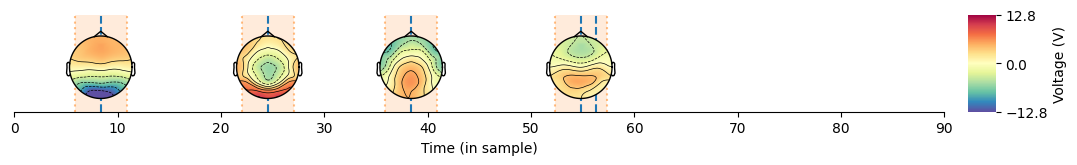

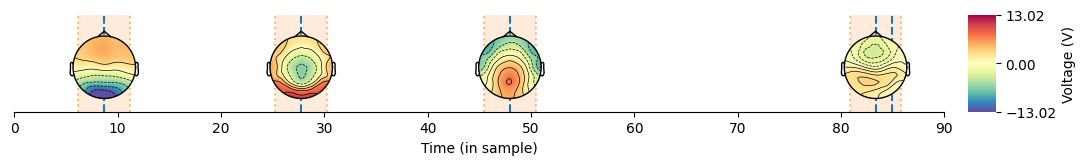

In [13]:
speed_epoch_data = epoch_data.where(epoch_data.cue == 'SP').stack({'trial':['participant','epoch']}).dropna('trial', how="all")
accuracy_epoch_data = epoch_data.where(epoch_data.cue == 'AC').stack({'trial':['participant','epoch']}).dropna('trial', how="all")

hmp.visu.plot_topo_timecourse(speed_epoch_data, estimates_cumulative, info, max_time=90)
hmp.visu.plot_topo_timecourse(accuracy_epoch_data, estimates_cumulative, info, max_time=90)

But in this case the HMP parameters are all shared across conditions so we might want to estimate the model separately for each condition if there is a reason to expect a difference. This is done by selecting the condition of interest and then estimating the model on the selected data.

In [14]:
speed_preprocessed_data = hmp.utils.condition_selection(preprocessed.data, 'SP', variable='cue')
trial_data_speed = hmp.trialdata.TrialData.from_preprocessed(speed_preprocessed_data, pattern=event_properties.template)

accuracy_preprocesssed_data = hmp.utils.condition_selection(preprocessed.data, 'AC', variable='cue')
trial_data_accuracy = hmp.trialdata.TrialData.from_preprocessed(accuracy_preprocesssed_data, pattern=event_properties.template)

  0%|          | 0/57 [00:00<?, ?it/s]

Transition event 1 found around time 100.0
Transition event 2 found around time 280.0
Transition event 3 found around time 530.0

All events found, refitting final combination.
Estimating 3 events model


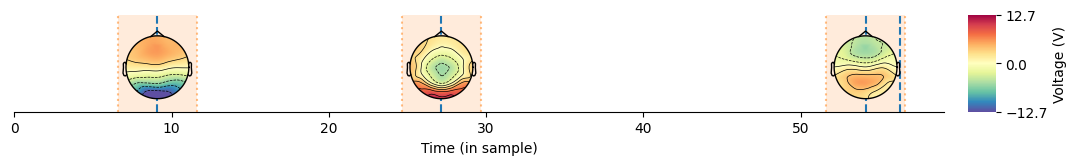

In [15]:
model_speed = hmp.models.CumulativeMethod(event_properties)
model.fit(trial_data_speed)
ll_cumulative, estimates = model.final_model.transform(trial_data_speed)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info,)

  0%|          | 0/86 [00:00<?, ?it/s]

Transition event 1 found around time 90.0
Transition event 2 found around time 290.0
Transition event 3 found around time 520.0
Transition event 4 found around time 820.0

All events found, refitting final combination.
Estimating 4 events model


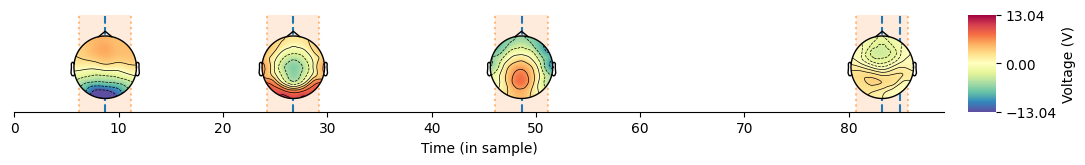

In [16]:
model_accuracy = hmp.models.CumulativeMethod(event_properties)
model.fit(trial_data_accuracy)
ll_cumulative, estimates = model.final_model.transform(trial_data_accuracy)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info,)

In this case, the models are completely independent and the cumulative method finds an additional event for the accuracy condition, but not for the speed condition.

In the two next advanced tutorials we cover how to build models that share some parameters between conditions or participants and how to properly select a given number of events using LOOCV.